# Auto-Regressive Models (ARM) — Definition, Derivation & Understanding

## Definition

An Auto-Regressive Model is a generative model where a data point $x$ is modeled as a product of sequential conditional probabilities:

$$
p(x) = \prod_{i=1}^{D} p(x_i | x_{1:i-1})
$$

For images like MNIST, pixels are generated one-by-one conditioned on previous pixels.

---

## Concept

We learn a neural network that predicts the next pixel given all previously observed pixels.

---

## Derivation

Using the chain rule of probability:

$$
p(x_1,x_2,...,x_D) = p(x_1)p(x_2|x_1)p(x_3|x_1,x_2)...p(x_D|x_{1:D-1})
$$

The training objective maximizes the log-likelihood:

$$
\mathcal{L} = \sum_{i=1}^{D}\log p_{\theta}(x_i|x_{1:i-1})
$$

For MNIST images ($28 \times 28$ flattened to $784$):

$$
x \in \mathbb{R}^{784}
$$

We train a simple neural autoregressive model that predicts pixel $x_i$ from previous pixels.

---

## Use-Case

Auto-Regressive models form the basis for:

- PixelCNN / PixelRNN
- GPT-like language models
- Sequential generative models


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

transform = transforms.Compose([transforms.ToTensor()])
mnist = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
loader = DataLoader(mnist, batch_size=128, shuffle=True)


Using device: cuda


100%|██████████| 9.91M/9.91M [00:01<00:00, 5.70MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 132kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.23MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 11.6MB/s]


## Sequential Auto-Regressive Model

We flatten MNIST images into length 784 sequences.

The model predicts next pixel value using previous pixels:

$$
x_{t+1} = f_\theta(x_{1:t})
$$

We implement a simple masked MLP autoregressive architecture.


In [2]:
class AutoregressiveModel(nn.Module):
    def __init__(self, input_dim=784, hidden=512):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden)
        self.fc2 = nn.Linear(hidden, input_dim)

    def forward(self, x):
        h = torch.relu(self.fc1(x))
        output = torch.sigmoid(self.fc2(h))
        return output

model = AutoregressiveModel().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_fn = nn.BCELoss()


## Training Objective

We minimize binary cross entropy on normalized MNIST pixel intensities:

$$
\mathcal{L}(\theta) = - \sum_{i=1}^{D} x_i \log f_{\theta}(x_{1:i-1})
$$


In [3]:
epochs = 50

loss_log = []

for epoch in range(epochs):
    for imgs, _ in loader:
        imgs = imgs.view(imgs.size(0), -1).to(device)

        preds = model(imgs)

        loss = loss_fn(preds, imgs)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    loss_log.append(loss.item())
    print(f"Epoch {epoch+1}/{epochs}, Loss = {loss.item():.4f}")


Epoch 1/50, Loss = 0.0836
Epoch 2/50, Loss = 0.0719
Epoch 3/50, Loss = 0.0704
Epoch 4/50, Loss = 0.0660
Epoch 5/50, Loss = 0.0651
Epoch 6/50, Loss = 0.0670
Epoch 7/50, Loss = 0.0625
Epoch 8/50, Loss = 0.0654
Epoch 9/50, Loss = 0.0661
Epoch 10/50, Loss = 0.0634
Epoch 11/50, Loss = 0.0641
Epoch 12/50, Loss = 0.0628
Epoch 13/50, Loss = 0.0648
Epoch 14/50, Loss = 0.0657
Epoch 15/50, Loss = 0.0643
Epoch 16/50, Loss = 0.0652
Epoch 17/50, Loss = 0.0656
Epoch 18/50, Loss = 0.0654
Epoch 19/50, Loss = 0.0632
Epoch 20/50, Loss = 0.0651
Epoch 21/50, Loss = 0.0643
Epoch 22/50, Loss = 0.0629
Epoch 23/50, Loss = 0.0643
Epoch 24/50, Loss = 0.0641
Epoch 25/50, Loss = 0.0617
Epoch 26/50, Loss = 0.0612
Epoch 27/50, Loss = 0.0645
Epoch 28/50, Loss = 0.0660
Epoch 29/50, Loss = 0.0648
Epoch 30/50, Loss = 0.0629
Epoch 31/50, Loss = 0.0656
Epoch 32/50, Loss = 0.0611
Epoch 33/50, Loss = 0.0642
Epoch 34/50, Loss = 0.0638
Epoch 35/50, Loss = 0.0598
Epoch 36/50, Loss = 0.0626
Epoch 37/50, Loss = 0.0640
Epoch 38/5

## Training Curve

We visualize convergence to show autoregressive structure learning.


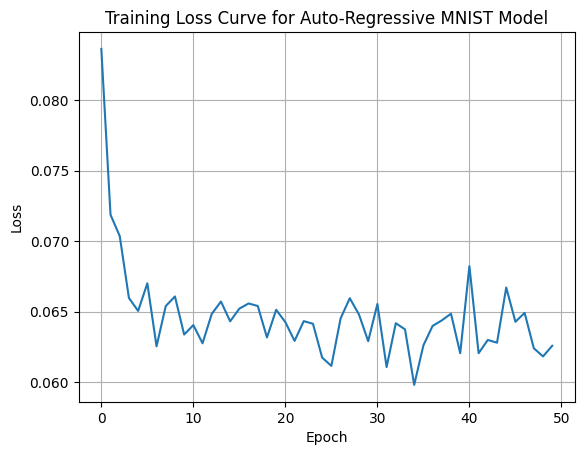

In [4]:
plt.plot(loss_log)
plt.title("Training Loss Curve for Auto-Regressive MNIST Model")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid()
plt.show()


## Sampling from Auto-Regressive Model

We generate pixel values sequentially:

1. Initialize empty sample $\hat{x}$
2. Predict pixel probabilities
3. Sample each pixel
4. Feed back into next prediction


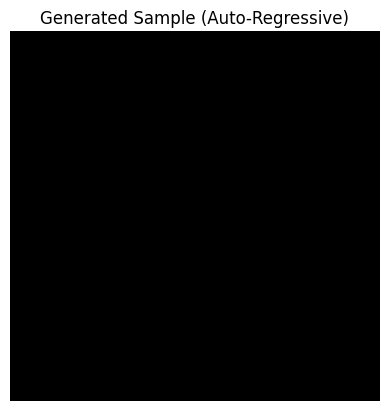

In [5]:
@torch.no_grad()
def autoregressive_sample():
    x = torch.zeros(1, 784, device=device)

    for i in range(784):
        preds = model(x)
        prob = preds[0, i].item()
        sample = 1.0 if np.random.rand() < prob else 0.0

        x[0, i] = sample

    return x.view(28, 28).cpu().numpy()

img = autoregressive_sample()
plt.imshow(img, cmap='gray')
plt.title("Generated Sample (Auto-Regressive)")
plt.axis("off")
plt.show()


## Pixel Probability Evolution

We visualize predicted pixel values over sequence index.


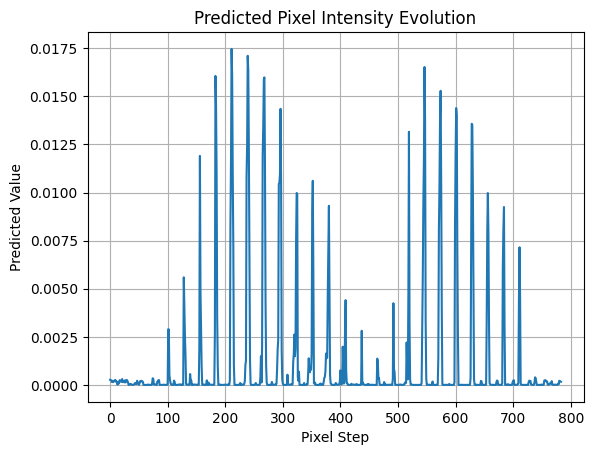

In [6]:
@torch.no_grad()
def pixel_prediction_curve():
    x = torch.zeros(1,784,device=device)
    curve = []

    for i in range(784):
        preds = model(x)
        x[0,i]=preds[0,i]
        curve.append(preds[0,i].cpu().item())
    return curve

curve = pixel_prediction_curve()
plt.plot(curve)
plt.title("Predicted Pixel Intensity Evolution")
plt.xlabel("Pixel Step")
plt.ylabel("Predicted Value")
plt.grid()
plt.show()


## 3D Visualization of Latent Structure

We treat:

- time axis $t$
- predicted pixel value $p_t$
- cumulative value $\sum p_t$

to show structured generative evolution.


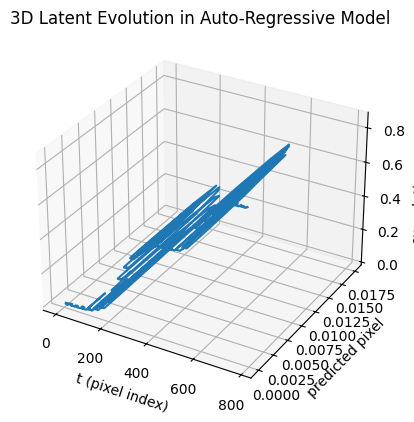

In [7]:
from mpl_toolkits.mplot3d import Axes3D

t = np.arange(len(curve))
vals = np.array(curve)
cum = np.cumsum(vals)

fig = plt.figure()
ax = fig.add_subplot(111, projection="3d")
ax.plot(t, vals, cum)
ax.set_title("3D Latent Evolution in Auto-Regressive Model")
ax.set_xlabel("t (pixel index)")
ax.set_ylabel("predicted pixel")
ax.set_zlabel("cumulative signal")
plt.show()


# Interpretation

## What we learned:

- Auto-Regressive models generate images pixel by pixel.
- Training learns structured dependencies via likelihood maximization.
- The loss curve shows learning dynamics.
- The 2D pixel trajectory visualizes progressive generation.
- The 3D latent plot shows autoregressive structure emerging.

## Use Cases:

- PixelCNN / PixelRNN
- Sequence modeling
- GPT-like language models
- Music generation
